In [1]:
using HierarchicalDriving
import POMDPs:initial_state
using POMDPToolbox
using Interact

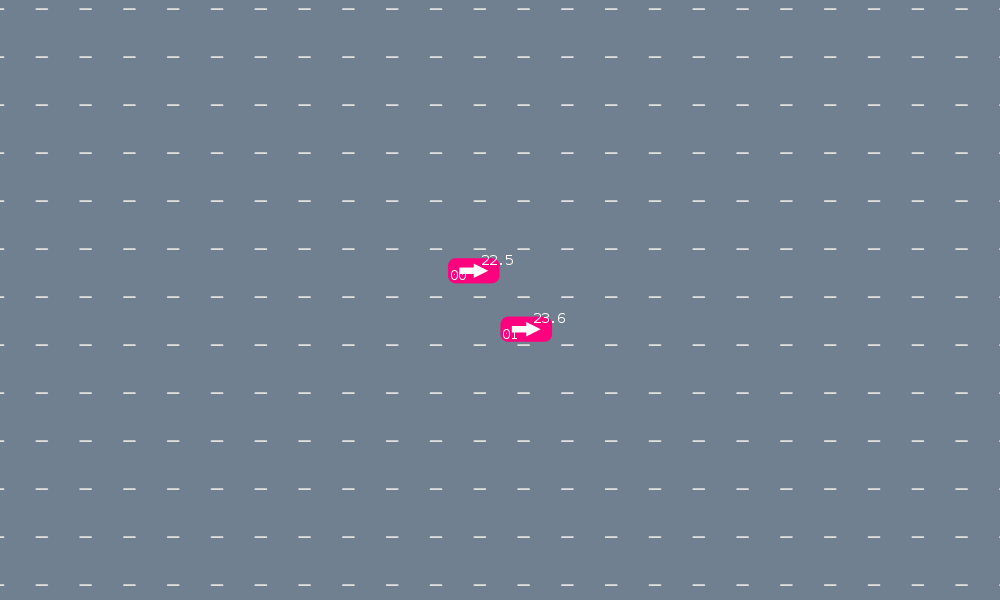

In [7]:
p = MaintainAt25POMDP()
s = initial_state(p, MersenneTwister(5))

Interact.Options{:SelectionSlider,Int64}(input-2: Signal{Int64}(11, nactions=1),"i",11,"11",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(18=>"18",2=>"2",16=>"16",11=>"11",21=>"21",7=>"7",9=>"9",10=>"10",19=>"19",17=>"17"…)),Any[],Any[],true,"horizontal")

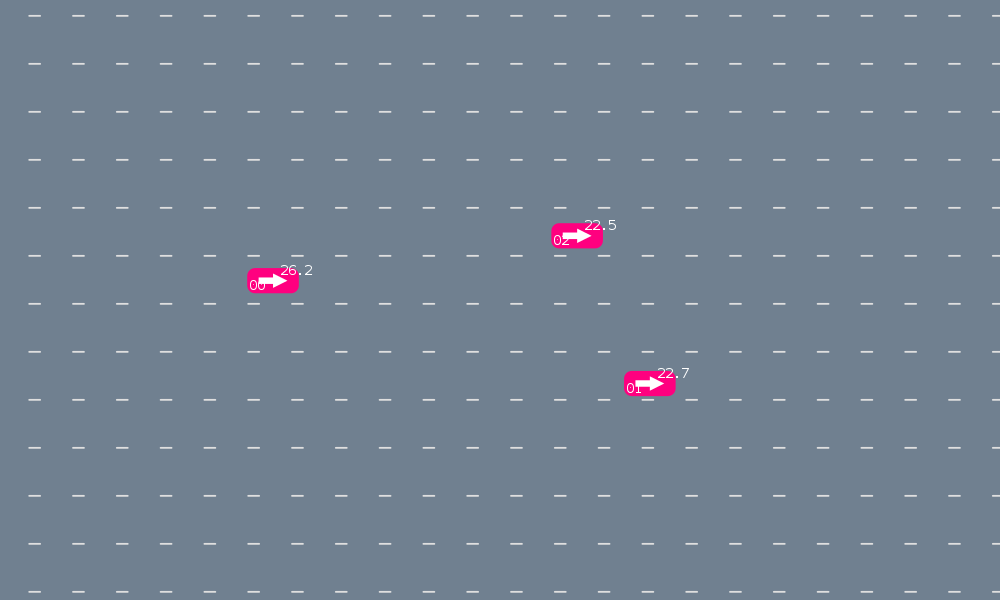

In [8]:
policy = RandomPolicy(p)
hr = HistoryRecorder(max_steps = 20)
hist = simulate(hr, p, policy)
@manipulate for i in 1:n_steps(hist)+1
    state_hist(hist)[i]
end